# Heading

Description

In [55]:
import numpy as np 

n_elems = 100

xmin = -1.
xmax = 1.
cellwidth = (xmax-xmin)/n_elems
x = np.linspace(xmin + cellwidth/2., xmax-cellwidth/2., n_elems)

DENS = 0
MOMX = 1
MOMY = 2 
ENER = 3
VELX = 1
VELY = 2
PRES = 3
FWD = 1
BWD = -1

freeflow = np.zeros((1,4))
freeflow[:,DENS] = 1.
freeflow[:,MOMX] = 1.
freeflow[:,MOMY] = 0.
freeflow[:,ENER] = 2. 

u = np.zeros((n_elems, 4))
u[:,:] = freeflow
u[np.abs(x)<0.2,DENS] = 1.1 + 0.1*np.cos(5*np.pi*x[np.abs(x)<0.2])
u[np.abs(x)<0.2,MOMX] = 1.1 + 0.1*np.cos(5*np.pi*x[np.abs(x)<0.2])




[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99  0]
[99  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94
 95 96 97 98]


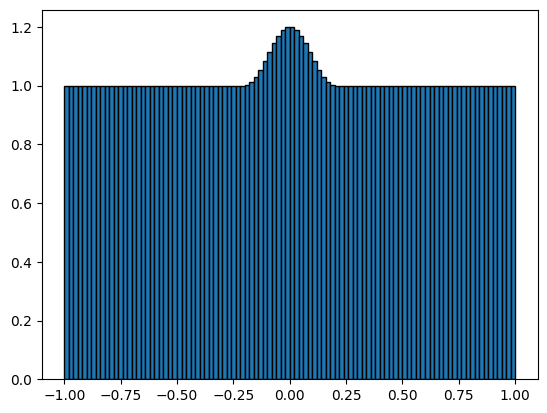

In [56]:
from matplotlib import pyplot as plt

plt.figure()
plt.bar(x, u[:,DENS], width=cellwidth, edgecolor='black')

il = np.concatenate(([n_elems-1], np.arange(n_elems-1)))
ir = np.concatenate((np.arange(1, n_elems), [0]))

print(ir)
print(il)

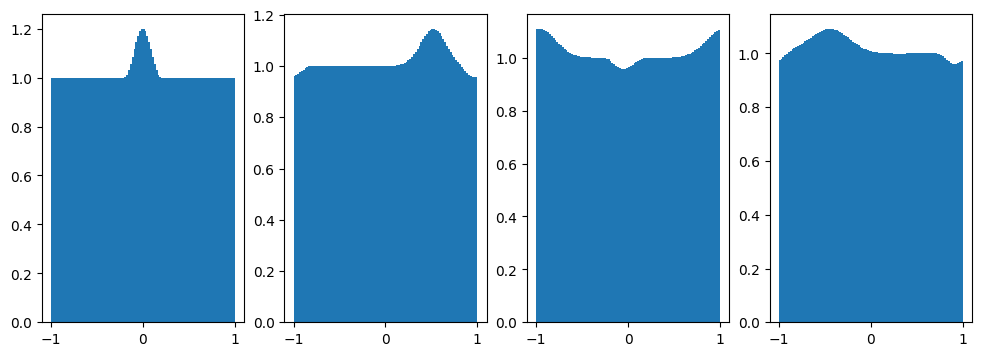

In [57]:
import helpers 
import copy

# calculate flux 
def constoprim(u):
    up = copy.deepcopy(u)
    up[:,VELX] = u[:,MOMX] / u[:,DENS]
    up[:,VELY] = u[:,MOMY] / u[:,DENS]
    up[:,PRES] = 0.4*(u[:,ENER] - 0.5* u[:,DENS] * (up[:,VELX]**2 + up[:,VELY]**2) )
    return up


def flux(u, up):
    f = np.zeros_like(u)
    
    f[:,DENS] = up[:,VELX] * up[:,DENS]
    f[:,MOMX] = up[:,VELX]**2 * up[:,DENS] + up[:,PRES]
    f[:,MOMY] = up[:,VELX]*up[:,VELY]*up[:,DENS]
    f[:,ENER] = up[:,VELX]*( u[:,ENER] + up[:,PRES] )
    return f


def sos(up): 
    return np.sqrt(1.4*up[:,PRES]/up[:,DENS])


def lmbda(up): 
    return sos(up)+np.sqrt(up[:,VELX]**2+up[:,VELY]**2)

def timestep(up): 
    return 0.99*cellwidth/np.max(lmbda(up))

def calc_flux(u, up): 
    f = flux(u, up) 
    # TODO: There seems to be a bug in roe
    # TODO: double check use of ir, il
    # f = 0.5 * (f + f[ir,:]) - helpers.stabilization_roe(u, up, u[ir,:], up[ir,:])
    a = np.maximum(lmbda(up), lmbda(up[ir,:]))
    f = 0.5 * (f + f[ir,:]) - 0.5 * a[...,np.newaxis] * (u[ir,:]-u)
    return f


def change_of_state(f, up): 
    # add flux to cells 
    return timestep(up)/cellwidth*(f[il,:]-f) 

SHOW = MOMX
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(12, 4)
ax[0].bar(x, u[:,SHOW], width=cellwidth)

for ifig in range(1,4):
    for _ in range(50): 
        up = constoprim(u)
        f = calc_flux(u, up)
        u = u + change_of_state(f, up)
    ax[ifig].bar(x, u[:,SHOW], width=cellwidth)


